# [2023-10-31] Circadian factor stability

In this notebook, we begin to examine the stability of fitted factors.

Specifically, we compare the factors fitted to models $(50, \{4,8\}, 30)$.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import wandb

import pandas as pd 
import numpy as np
import itertools
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from kf_viz import draw_syllable_factors, draw_circadian_bases

sns.set_style("darkgrid")

In [2]:
## WandB helper functions, to be refactored
def get_results_df(entity, project, config_keys, summary_keys):
    """Project is specified by <entity/project-name>"""
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(f"{entity}/{project}")

    run_results = {key: [] for key in itertools.chain(['id', 'name'], config_keys, summary_keys)}

    for run in runs: 

        # .summary contains the output keys/values for metrics like accuracy.
        # use .get to catch NaN runs (e.g. due to OOM)
        for key in summary_keys:
            run_results[key].append(run.summary.get(key,))

        # .config contains the hyperparameters.
        for key in config_keys:
            run_results[key].append(run.config[key])

        # .name is the human-readable name
        run_results['name'].append(run.name)
        run_results['id'].append(run._attrs['name'])

    return pd.DataFrame(run_results)

def download_params(entity: str, project: str, run_id: str):
    """Return tuple of params for the given run."""

    api = wandb.Api()

    run = api.run(f"{entity}/{project}/{run_id}")

    # run.file(...).download(...) only seems to recognize paths relative to cwd
    rel_path = f'../temp/{run_id}'

    # If file already exists, do not re-download
    run.file("params.npz").download(root=rel_path, exist_ok=True)

    params = np.load(Path(rel_path)/'params.npz')

    return params['G'], params['F1'], params['F2'], params['F3']


## Load all runs associated with (K1=50, K2={4,8}, K3=30)

Pull data from WandB server into a Pandas dataframe.

In [3]:
# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

config_keys = ['seed', 'k1', 'k2', 'k3']
summary_keys = ['pct_dev']

df = get_results_df(wnb_entity, wnb_project, config_keys, summary_keys)

In [4]:
# Choose runs for which (K1=50, K2=4)
df = df[(df['k1'] == 50) \
        & ((df['k2'] == 4) | (df['k2'] == 8)) \
        & (df['k3'] == 30)]

# Drop rows that have NaN pct_dev
df = df.dropna(axis=0)

print(f"{len(df)} total runs, {df['k2'].nunique()} unique K_2 ranks: {sorted(df['k2'].unique())}")

9 total runs, 2 unique K_2 ranks: [4, 8]


## Evaluate K2=4 factors

I expected the model with $K_3=100$ to be overfit to the data, and hence for the held-out log likelihood to be lower
than simpler models that do not overfit to the data. However, this may be too naive of an assumption.

# Fitted behavioral topics

Text(0.5, 0.98, 'k2 = 4')

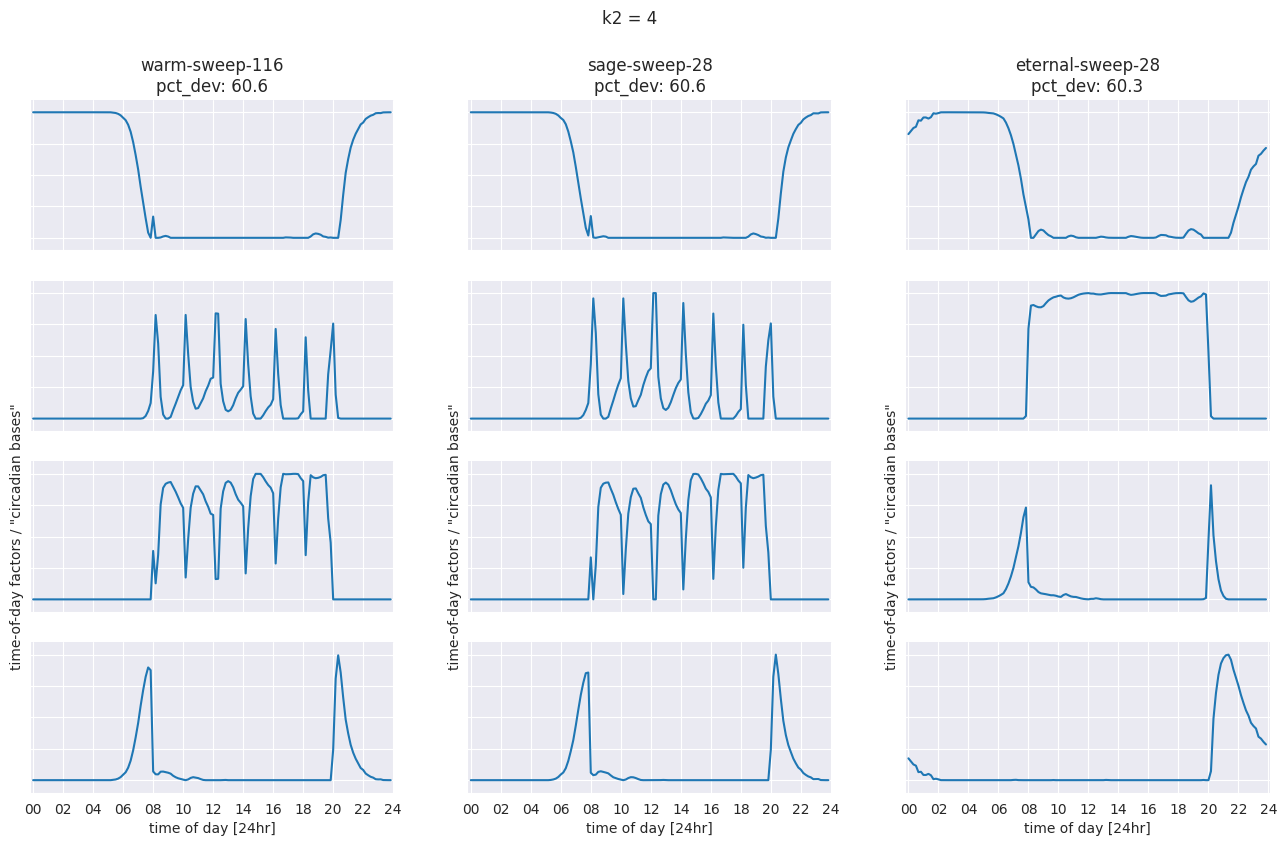

In [5]:
k2 = 4

# -------------------------------------------
subdf = df[df['k2'] == k2]
params = [download_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _params in enumerate(params):
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

## Evaluate on K2=8

Text(0.5, 0.98, 'k2 = 8')

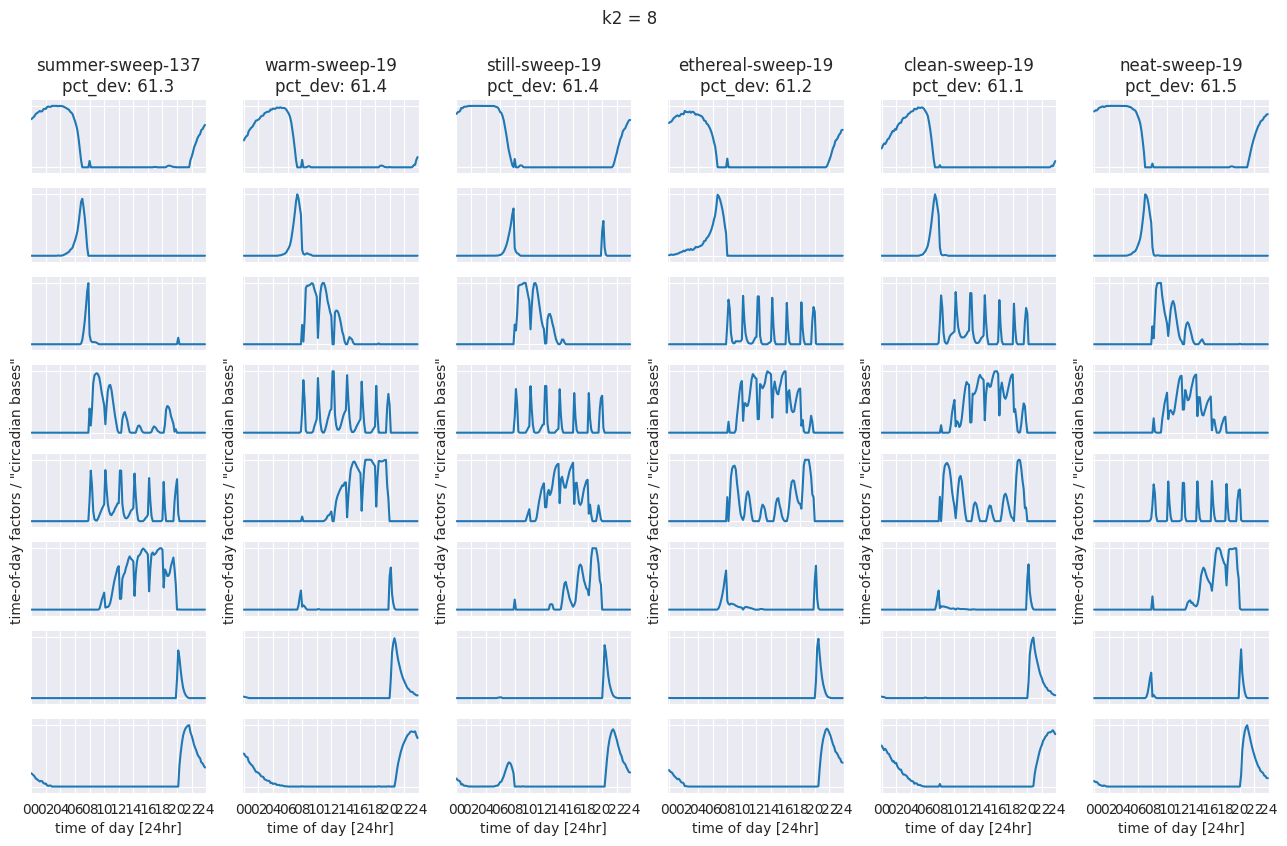

In [6]:
k2 = 8

# -------------------------------------------
subdf = df[df['k2'] == k2]
params = [download_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _params in enumerate(params):
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

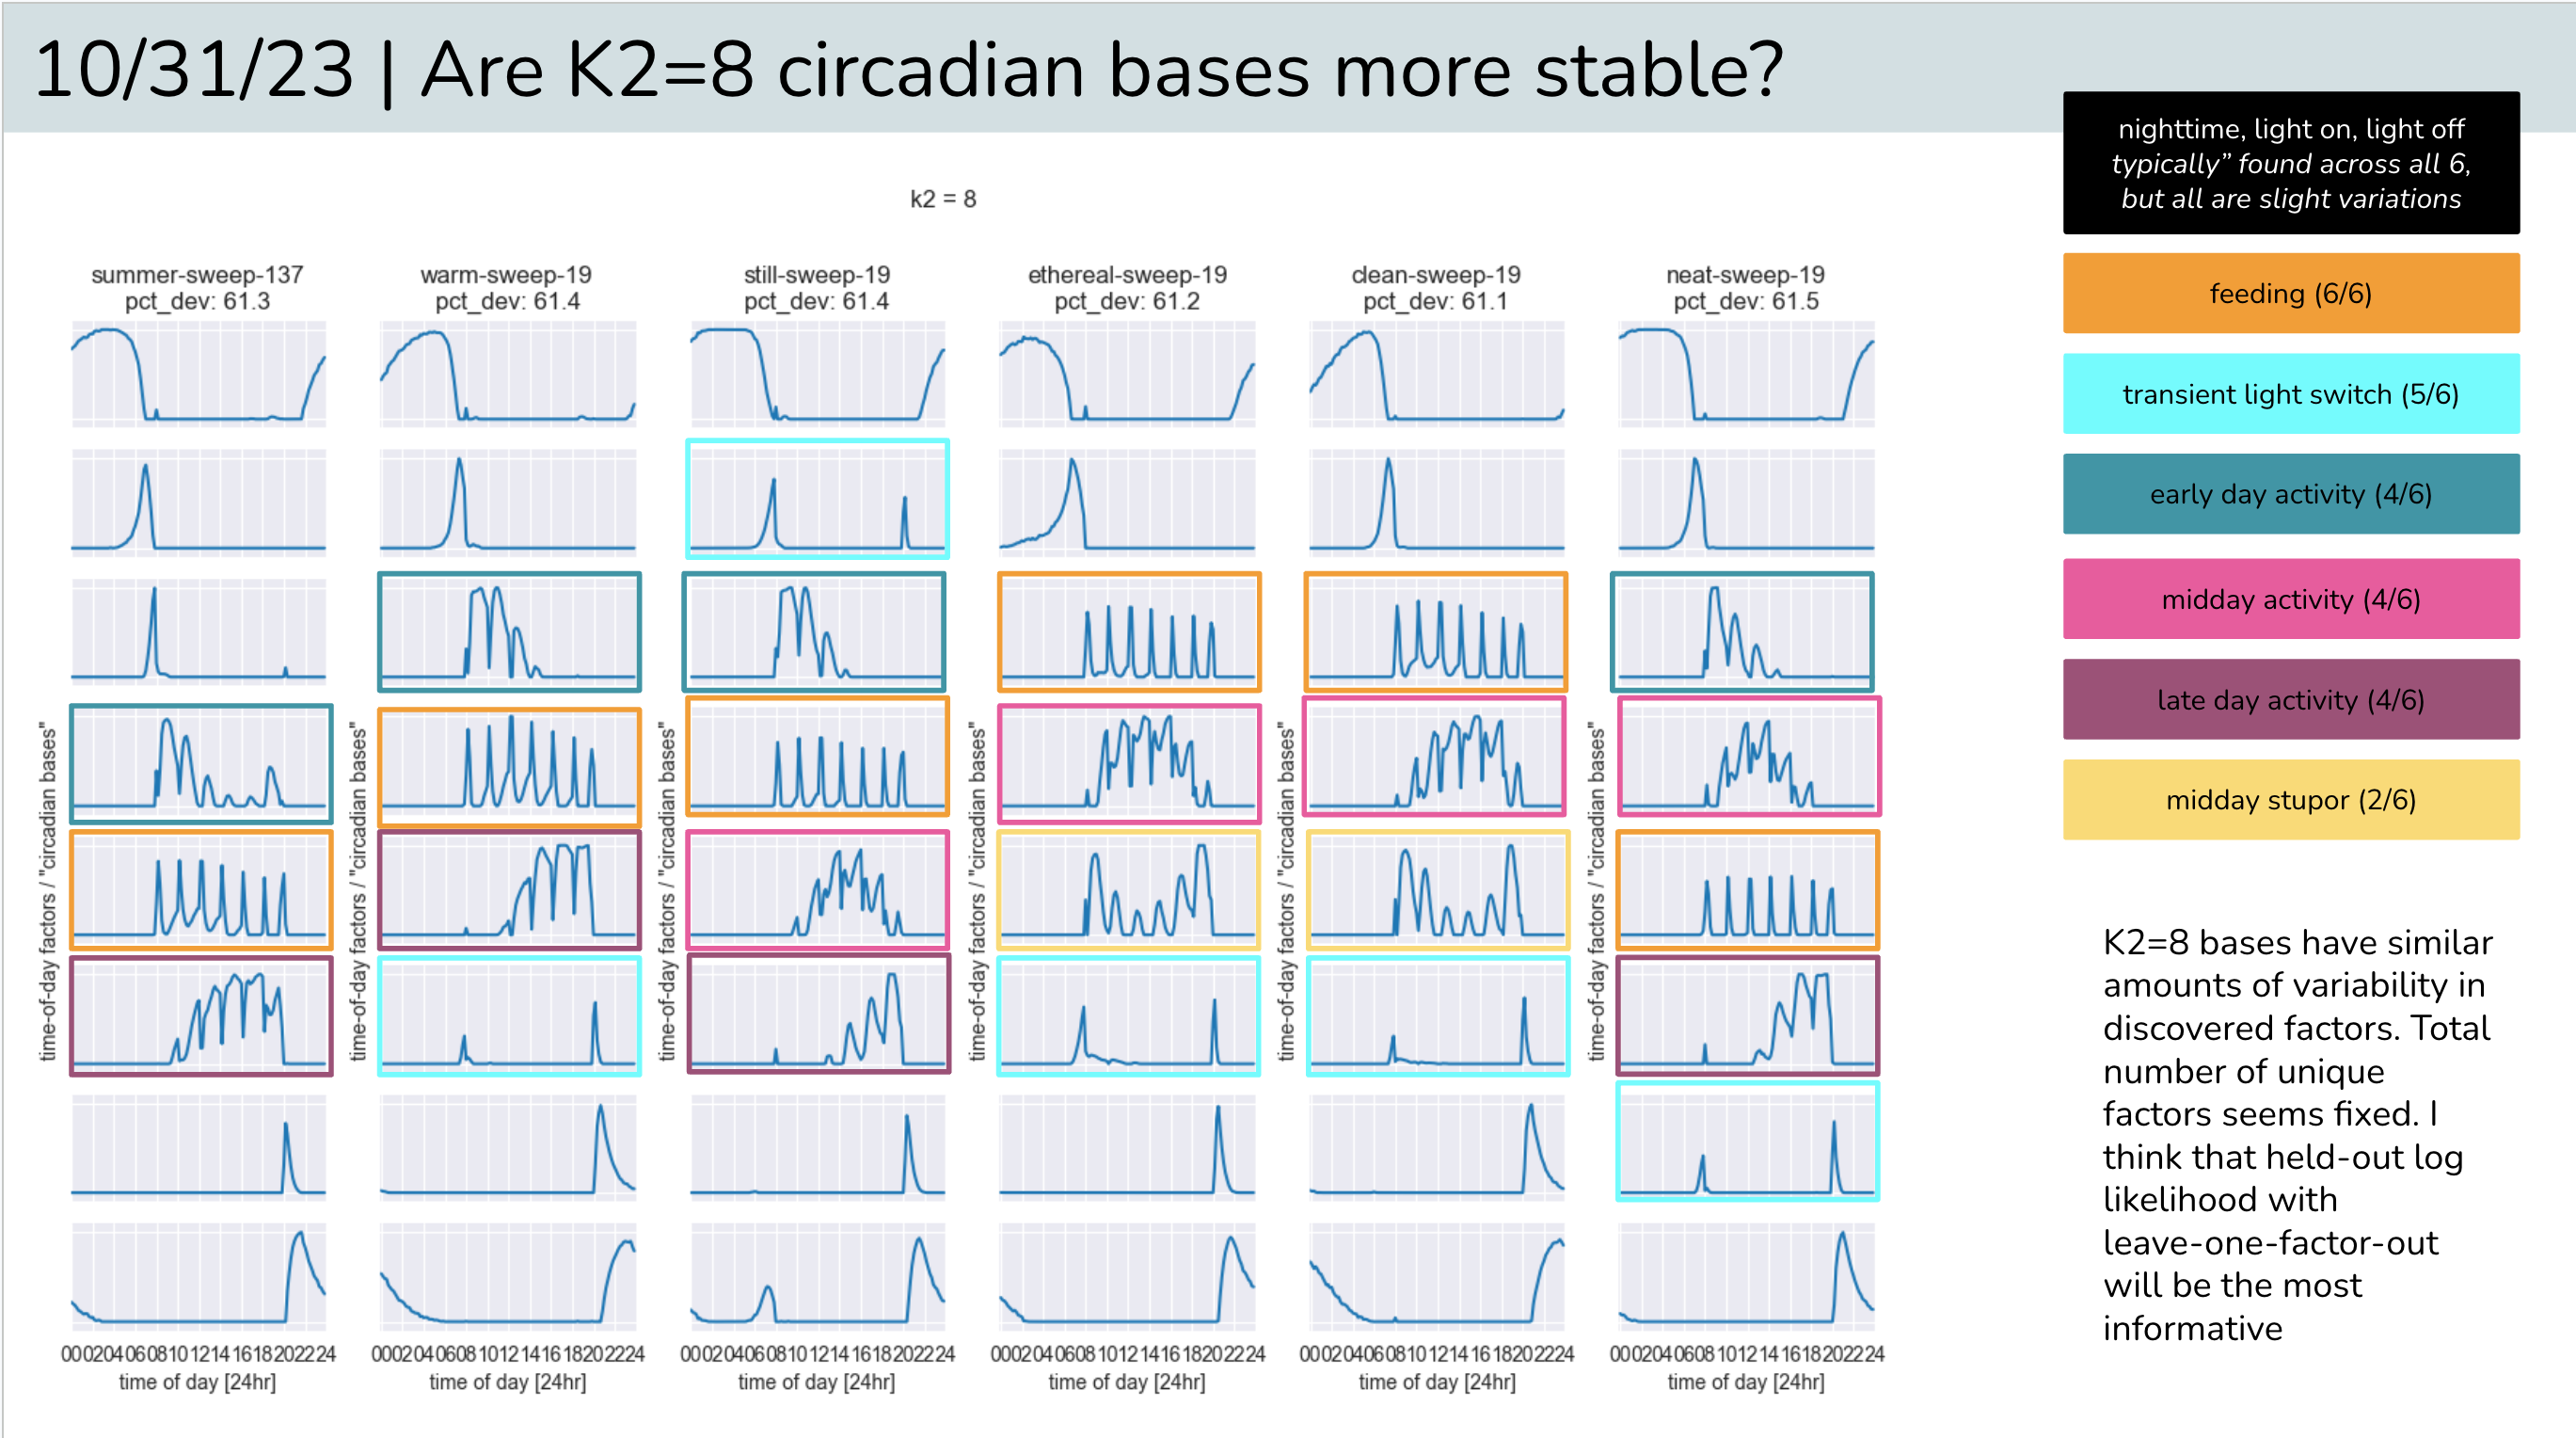